In [1]:
import torch
import os
import inspect
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image, ImageSequence

# Setup the place365 model

In [82]:
arch = 'resnet50'
model_file = "{}_places365.pth.tar".format(arch)

In [83]:
# if the pre-trained model is not exist, download it
if not os.access(model_file, os.F_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)
else:
    print("{} is already downloaded.".format(model_file))

resnet50_places365.pth.tar is already downloaded.


In [109]:
model = models.__dict__[arch](num_classes=365)

### Attach a hook

In [108]:
# hook_outputs = [0]
# def for_hook(module, input, output):
#     global hook_outputs
#     hook_outputs=input
    
# handle = model.fc.register_forward_hook(for_hook)

## Load pre-trained weight

In [85]:
#Load all tensors onto the CPU, using a function
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

In [86]:
# Get state_dict and Remove the pre-fix "module."
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Pre-process

In [87]:
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [88]:
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

## Load image
Get filelist by *find_files_main*

In [125]:
file_list = ['IC0015QCD.jpg.ldcc', 'IC0015QCE.jpg.ldcc']

In [89]:
file_list = ['HC00001YG.jpg.ldcc',
 'HC00001YU.jpg.ldcc',
 'IC0015LGS.jpg.ldcc',
 'IC0015LGT.jpg.ldcc',
 'IC0015LGU.jpg.ldcc',
 'IC0015LGV.jpg.ldcc',
 'IC0015LGY.jpg.ldcc',
 'IC0015LGZ.jpg.ldcc',
 'IC0015LH0.jpg.ldcc',
 'IC0015LH1.jpg.ldcc',
 'IC0015LH2.jpg.ldcc',
 'IC0015LH3.jpg.ldcc',
 'IC0015LH4.jpg.ldcc',
 'IC0015LH5.jpg.ldcc',
 'IC0015LH6.jpg.ldcc',
 'IC0015LH7.jpg.ldcc',
 'IC0015LH8.jpg.ldcc',
 'IC0015LH9.jpg.ldcc',
 'IC0015LHA.jpg.ldcc',
 'IC0015LHB.jpg.ldcc',
 'IC0015LHC.jpg.ldcc',
 'IC0015LHD.jpg.ldcc',
 'IC0015LHE.jpg.ldcc',
 'IC0015LHF.jpg.ldcc',
 'IC0015LHG.jpg.ldcc']

In [126]:
dataFolder = 'data/LDC2018E52_AIDA_Scenario_1_Seedling_Corpus_Part_2/extracted_data/jpg-data/'
files = [None] * len(file_list)
for i in range(len(file_list)):
    files[i] = (dataFolder + file_list[i])[:-5]

In [127]:
f_write = open('data/tag_bounding/scene_score.csv','w')
f_index = open('data/tag_bounding/scene_score_index.csv','w')
for img_name in files:
    if img_name[-3:] == 'gif' or img_name[-3:] == 'png':
        img = Image.open(img_name).convert(mode='RGB')
    else:
        img = Image.open(img_name)
    input_img = V(centre_crop(img).unsqueeze(0))

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    
    # output prediction
    print('{} prediction on {}'.format(arch,img_name))

    for i in range(4):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
        f_write.write(classes[idx[i]]+'\t')
        f_index.write(str(idx[i].item())+'\t')
    print('{:.3f} -> {}'.format(probs[4], classes[idx[4]]))
    f_write.write(classes[idx[4]]+'\n')
    f_index.write(str(idx[4].item())+'\n')
f_write.close()
f_index.close()

resnet50 prediction on data/LDC2018E52_AIDA_Scenario_1_Seedling_Corpus_Part_2/extracted_data/jpg-data/IC0015QCD.jpg
0.011 -> swamp
0.011 -> excavation
0.011 -> library/outdoor
0.009 -> lawn
0.009 -> museum/indoor
resnet50 prediction on data/LDC2018E52_AIDA_Scenario_1_Seedling_Corpus_Part_2/extracted_data/jpg-data/IC0015QCE.jpg
0.011 -> library/outdoor
0.011 -> swamp
0.010 -> excavation
0.009 -> museum/indoor
0.009 -> amphitheater


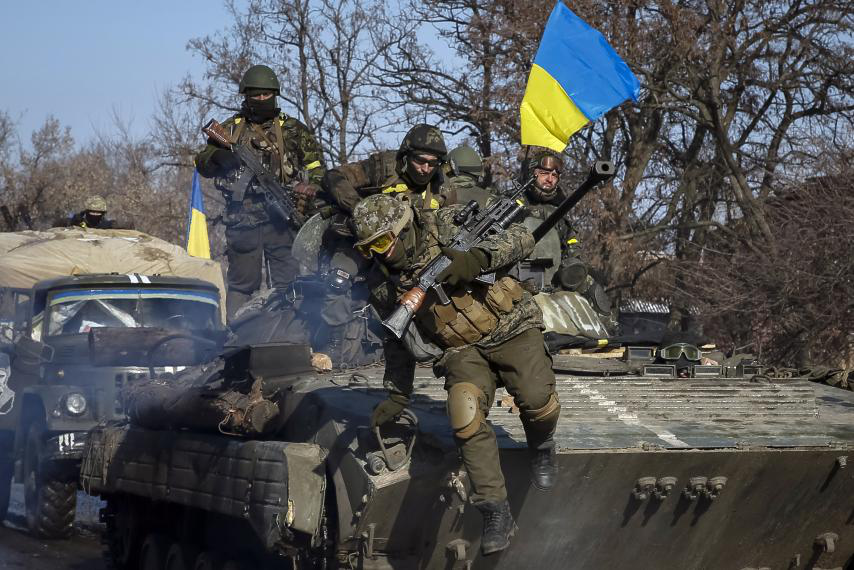

In [131]:
Image.open('data/LDC2018E52_AIDA_Scenario_1_Seedling_Corpus_Part_2/extracted_data/jpg-data/IC0015QCE.jpg')

# Check result

In [92]:
import pandas

In [102]:
df = pandas.read_csv('data/tag_bounding/scene_score.csv',sep='\t',header=None)
df_index = pandas.read_csv('data/tag_bounding/scene_score_index.csv',sep='\t',header=None)

# Post-process

### Deduplicate

In [103]:
np_index = list(set(df_index.values.flatten()))
scenes = [None] * len(np_index)

In [104]:
for i in range(len(np_index)):
    scenes[i] = classes[np_index[i]]

In [117]:
scenes

['airplane_cabin',
 'amphitheater',
 'pet_shop',
 'amusement_park',
 'excavation',
 'phone_booth',
 'physics_laboratory',
 'fastfood_restaurant',
 'playground',
 'fire_escape',
 'arena/performance',
 'flea_market/indoor',
 'pub/indoor',
 'army_base',
 'art_studio',
 'art_gallery',
 'assembly_line',
 'art_school',
 'auditorium',
 'restaurant',
 'bakery/shop',
 'gift_shop',
 'ballroom',
 'bank_vault',
 'banquet_hall',
 'bar',
 'schoolhouse',
 'science_museum',
 'shopfront',
 'bazaar/indoor',
 'bazaar/outdoor',
 'shower',
 'ski_resort',
 'beauty_salon',
 'sky',
 'slum',
 'beer_garden',
 'beer_hall',
 'ice_cream_parlor',
 'stadium/football',
 'stadium/soccer',
 'stage/outdoor',
 'stage/indoor',
 'booth/indoor',
 'sushi_bar',
 'bullring',
 'jail_cell',
 'jewelry_shop',
 'junkyard',
 'butchers_shop',
 'television_studio',
 'kennel/outdoor',
 'cafeteria',
 'ticket_booth',
 'temple/asia',
 'landfill',
 'tower',
 'toyshop',
 'campsite',
 'candy_store',
 'carrousel',
 'trench',
 'legislative_cha

### Split some complex classes

In [121]:
scenes_new = []
for s in scenes:
    for i in range(len(s)):
        if s[i]=='/':
            scenes_new.append(s[:i])
#             scenes_new.append(s[i+1:])
            break
        else:
            continue
        break

In [122]:
scenes_new = list(set(scenes_new))

In [123]:
scenes_new

['diner',
 'bazaar',
 'stadium',
 'market',
 'kennel',
 'bakery',
 'booth',
 'flea_market',
 'museum',
 'temple',
 'pub',
 'stage',
 'arena']